<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_2_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

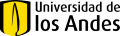

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Mini Proyecto 2, Técnicas de *Deep Learning*: Clasificación de Sentimientos de Reseñas de Películas en *IMDB* con Redes Neuronales Recurrentes**

## **Descripción del problema:**

XXXXXX

## **Objetivo:**

XXXXX

## **Resumen:**

XXXX

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 9 de mayo.**


# Tareas

* Exploración y pre-procesamiento (Jordan)

* Introducción, y explicación de las opciones tomadas en el PDF (Andrés y Jordan)

* Validar cual es mejor Word2vec o Glove (Andrés y Jordan)  Busqueda bibliográfica para explicar informe

* LSTM o GRU  (Andrés)

* Pensar en ideas visualización (Andrés y Jordan)

* Entrenamiento y evaluación de modelo (Andrés)


***
# **Índice**

El *notebook* abordará el proyecto de la siguiente manera:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣ | **Instalación y carga de librerías** |
| 2️⃣ | **Análisis exploratorio y preparación de los datos**       |
| 3️⃣ | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣ | **Pipeline de preprocesamiento ...**   |
| 4️⃣ | **Desarrollo del modelo RNN...**   |
| 4️⃣.1️⃣ | **Hiperparámetros, partición y Dataloaders**   |
| 4️⃣.2️⃣ | **Adaptación a partir de la arquitectura ...*   |
| 4️⃣.3️⃣ | **Entrenamiento, validación y prueba**   |
| 5️⃣ | **Análisis de resultados y conclusiones**   |
| 6️⃣ | **Referencias**   |



***

# 1. Instalación y cargue de librerías

Empezamos por el cargue de las librerias que se usarán para efectos de este proyecto. Estas incluyen:

* Librerías comunes para la lectura, procesamiento y ploteo básico de las imágenes.
* **`kagglehub`**, para poder descargar el dataset del miniproyecto de forma conveniente
* **`pytorch`** (de acuerdo, a la sugerencia del enunciado del proyecto) ....

In [36]:
pip install kagglehub # Necesario para ejecutarse en Coursera

In [59]:
# Librerías comunes
import os
import random
import time
import numpy as np
import pandas as pd

# Preprocesamiento
from collections import Counter

# Librerías NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

# Modelado
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import torch.optim as optim

# Evaluación
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from tqdm import tqdm

# Descarga del dataset
import kagglehub
path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")
print("Datos descargados en:", path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Datos descargados en: /kaggle/input/imdb-movie-ratings-sentiment-analysis


In [38]:
# Descarga de palabra vacías
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [39]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ['numpy', 'pandas', 'torch', 'torchvision', 'scikit-learn', 'kagglehub', 'pillow','matplotlib','seaborn']
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
torchvision :  0.21.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
pillow :  11.2.1
matplotlib :  3.10.0
seaborn :  0.13.2


El siguiente bloque de código nos permite hacer determininísticas las funciones traídas de **`pytorch`**, y en general controlar todos los pseudo-aleatorios del *notebook*

In [40]:
# Definición del random state y seeds
RANDOM_STATE = 13
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

XXXXXXX   Esto se detalla posteriormente en la sección **Pipeline de Preprocesamiento**.

In [41]:
# Descargar el conjunto de datos y almacenar el path en una variable
data = pd.read_csv(os.path.join(path, 'movie.csv'))
print(data.head())
# Frecuencia relativa de cada clase
print(data['label'].value_counts(normalize=True))

                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1
label
0    0.500475
1    0.499525
Name: proportion, dtype: float64


In [42]:
print(data.columns)

Index(['text', 'label'], dtype='object')


Una vez teniendo esta información pre-cargada, hacemos un breve análisis de nuestro conjunto de datos. Empezando por la distribución de las clases:

In [43]:
# data_raw.shape

In [44]:
# data = data_raw.copy()
# data.isna().sum()

In [45]:
# data.duplicated().sum()

In [46]:
# # Nombres de las clases
# ods = np.array([
#     "Fin de la pobreza", "Hambre cero", "Salud y bienestar", "Educación de calidad", "Igualdad de género",
#     "Agua limpia y saneamiento", "Energía asequible y no contaminante", "Trabajo decente y crecimiento económico",
#     "Industria, innovación e infraestructura", "Reducción de las desigualdades", "Ciudades y comunidades sostenibles",
#     "Producción y consumo responsables", "Acción por el clima", "Vida submarina", "Vida de ecosistemas terrestres",
#     "Paz, justicia e instituciones sólidas"
# ])
# counts = data['ODS'].value_counts()
# # Plot del número de documentos por categoría
# fig, ax = plt.subplots(1, 1, figsize=(5,5))
# norm = plt.Normalize(vmin=counts.min(), vmax=counts.max())
# colors = cm.viridis(norm(counts))
# ax.barh(range(0,16), counts,color=colors)
# ax.set_yticks(range(0,16), labels=[ods[l-1] + f" ({l})" for l in counts.index])
# ax.invert_yaxis()
# fig.show()

xxxxxx

Idiomas xxxx

In [47]:
# #Identifica el Idioma de cada fila
# def identificar_idioma(X: pd.DataFrame):
#     X["idioma"] = X['textos'].apply(lambda x: detect(x) if isinstance(x, str) and x.strip() else "desconocido")
#     return X

# X_deteccion = identificar_idioma(data)
# print(X_deteccion['idioma'].value_counts())

In [48]:
# indices_a_traducir = data[data['idioma'] != 'es'].index
# translator = Translator()

# # Traducción hecha con google translate
# def traducir_texto_fila(fila):
#     texto = fila['textos']
#     idioma_original = fila['idioma']
#     if isinstance(texto, str) and texto.strip():
#         return translator.translate(texto, src=idioma_original, dest="es").text
#     return texto

# # Aplicando la traducción
# data.loc[indices_a_traducir, 'textos'] = data.loc[indices_a_traducir].apply(traducir_texto_fila, axis=1)

# # Ahora los textos han sido traducios al español
# for texto in data.loc[indices_a_traducir, 'textos']:
#     print(texto, "\n")

In [49]:
# nltk_stopwords_set = set(stopwords.words("spanish"))

In [50]:
# def preprocesamiento_exploratorio(X: pd.DataFrame):
#     # Tokenizar a nivel de palabra y pasar a minúsculas
#     tokenizer = RegexpTokenizer(r"\b[a-zA-ZáéíóúüñÁÉÍÓÚÜÑ'-]+")

#     X_preprocesado = X.apply(lambda x: tokenizer.tokenize(x))
#     X_preprocesado = [[t.lower() for t in text] for text in X_preprocesado]

#     # Filtrar palabras vacías
#     X_preprocesado = [[token for token in text if token not in nltk_stopwords_set] for text in X_preprocesado]
#     texto_nube = ' '.join(word for text in X_preprocesado for word in text)
#     return texto_nube

In [51]:
# #Visualización inicial de las palabras que contienen los documentos.
# texto_nube = preprocesamiento_exploratorio(X_train['textos'])

# # Generación Nube de Palabras
# wordcloud = WordCloud(
#     width=800,
#     height=400,
#     background_color ='white',
#     min_font_size=10,
#     max_font_size=110,
#     max_words=100
# ).generate(texto_nube)
# plt.figure(figsize=(10, 10))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()

In [52]:
# #Conversión a dataframe
# def palabras_a_dataframe(texto):
#     palabras = texto.split()  # Dividir el texto en palabras por espacios
#     conteo = Counter(palabras)  # Contar ocurrencias de cada palabra
#     df = pd.DataFrame(conteo.items(), columns=['Palabra', 'Frecuencia'])
#     df = df.sort_values(by='Frecuencia', ascending=False).reset_index(drop=True)  # Ordenar y resetear índice
#     return df

# conteo_palabras = palabras_a_dataframe(texto_nube)
# conteo_top = conteo_palabras.head(20)

# # Top 20 palabras
# plt.figure(figsize=(5, 5))
# sns.barplot(x=conteo_top["Frecuencia"], y=conteo_top["Palabra"], palette="viridis")
# plt.xlabel("Frecuencia")
# plt.ylabel("Palabra")
# plt.title(f"Top {20} Palabras más Frecuentes")
# plt.show()

In [53]:
# counts = data['ODS'].value_counts()
# counts_train = y_train.value_counts()

# # Gráfica de la proporcionalidad de las clases y los conjuntos divididos
# fig, ax = plt.subplots(1, 1, figsize=(5,5))
# ax.barh(range(0,16), counts, label="Test")
# ax.barh(range(0,16), counts_train, label="Train")
# ax.set_yticks(range(0,16), labels=[ods[l-1] + f" ({l})" for l in counts.index])
# ax.invert_yaxis()
# plt.title("Distribución del split estratificado")
# plt.legend()
# fig.show()

El objetivo de esta sección es incorporar varios estilos de pre-procesamiento, probar diferentes maneras de depurar los textos como por ejemplo remover caracteres no alfanuméricos, a excepción de guiones o apóstrofes. También haremos uso de dos normalizadores: *Stemming* y *Lemmatization*, ....

***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

...

...

In [58]:
english_stop = set(stopwords.words('english'))

def clean_and_tokenize(text):
    # extrae solo palabras alfabéticas
    tokens = re.findall(r'\b[a-zA-Z]+\b', text.lower())
    return [t for t in tokens if t not in english_stop]

# Prueba
example = data.loc[0, 'text']
print(clean_and_tokenize(example))

['grew', 'b', 'watching', 'loving', 'thunderbirds', 'mates', 'school', 'watched', 'played', 'thunderbirds', 'school', 'lunch', 'school', 'wanted', 'virgil', 'scott', 'one', 'wanted', 'alan', 'counting', 'became', 'art', 'form', 'took', 'children', 'see', 'movie', 'hoping', 'would', 'get', 'glimpse', 'loved', 'child', 'bitterly', 'disappointing', 'high', 'point', 'snappy', 'theme', 'tune', 'could', 'compare', 'original', 'score', 'thunderbirds', 'thankfully', 'early', 'saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'series', 'gerry', 'anderson', 'wife', 'created', 'jonatha', 'frakes', 'hand', 'directors', 'chair', 'version', 'completely', 'hopeless', 'waste', 'film', 'utter', 'rubbish', 'cgi', 'remake', 'may', 'acceptable', 'replacing', 'marionettes', 'homo', 'sapiens', 'subsp', 'sapiens', 'huge', 'error', 'judgment']


In [60]:
all_tokens = [tok for txt in data['text'] for tok in clean_and_tokenize(txt)]
freq = Counter(all_tokens)

# Top‑20 000 + <PAD>=0, <UNK>=1
vocab = {w:i+2 for i,(w,_) in enumerate(freq.most_common(20000))}
#Indicadores de inicio y final
vocab.update({'<PAD>':0,'<UNK>':1})

def encode(tokens, max_len=200):
    seq = [vocab.get(t,1) for t in tokens]
    # Completa secuencia hasta tener max_len
    return seq[:max_len] + [0]*(max_len-len(seq))

In [ ]:
# # Pipeline con Stemming, sin depuración de palabras
# pipeline_stem = Pipeline([
#     ('preprocesador', preprocesador(normalizer=normalizer_stem)),
#     ('vectorizer', TfidfVectorizer()),
# ])

In [ ]:
# # Stemming
# stemmer = SnowballStemmer("spanish")
# normalizer_stem = lambda tokens: [stemmer.stem(t) for t in tokens]

# # Lemmatization
# nlp = spacy.load("es_core_news_sm")
# normalizer_lemma = lambda tokens: [t.lemma_ for t in nlp(" ".join(tokens))]

***

# 4. Desarrollo del modelo RNN....

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

XXXXX

Se usa una partición **80/10/10** para los datos de entrenamiento, validación y *test*, respectivamente. También se define **`device`** que nos permitirá ir alternado el uso de GPU y de CPU.

In [61]:
class IMDBDataset(Dataset):
    def __init__(self, df, max_len=200):
        self.texts  = df['text'].tolist()
        self.labels = df['label'].astype(int).tolist()
        self.max_len = max_len
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        toks = clean_and_tokenize(self.texts[i])
        return torch.tensor(encode(toks,self.max_len)), torch.tensor(self.labels[i],dtype=torch.float)

# Split 80/10/10 con semilla fija
ds = IMDBDataset(data)
n = len(ds)
train_ds, val_ds, test_ds = random_split(ds, [int(.8*n),int(.1*n),n-int(.9*n)], generator=torch.Generator().manual_seed(42))

batch_size = 64
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size)
test_loader  = DataLoader(test_ds,  batch_size)

In [62]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, emb_dim=100, hid_dim=128, n_layers=2, bidir=True, drop=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm      = nn.LSTM(emb_dim, hid_dim, n_layers, bidirectional=bidir, batch_first=True, dropout=drop)
        self.dropout   = nn.Dropout(drop)
        self.fc        = nn.Linear(hid_dim*(2 if bidir else 1), 1)
    def forward(self, x):
        emb, _ = self.embedding(x), None
        out, _ = self.lstm(emb)
        h_last = out[:, -1, :]
        return torch.sigmoid(self.fc(self.dropout(h_last))).squeeze()

In [ ]:
# # Trabajar en GPU/CPU
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Partición de los datos
# size_dataset  = len(dataset)
# size_entrenmiento = int(0.8 * size_dataset)
# size_validacion = int(0.1 * size_dataset)
# size_test = size_dataset - size_entrenmiento - size_validacion
# dataset_train, dataset_val, dataset_test = random_split(
#     dataset,
#     [size_entrenmiento, size_validacion, size_test],
#     generator=torch.Generator().manual_seed(RANDOM_STATE)
# )

# # Carga "lazy" de las particiones
# train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
# val_loader   = DataLoader(dataset_val,   batch_size=batch_size, shuffle=False)
# test_loader  = DataLoader(dataset_test,  batch_size=batch_size, shuffle=False)

***

## 4.2. Adaptación a partir ...
</span>

***
### 4.2.1 Modelo: ...

... s capaz de detectar tanto bordes como patrones complejos. Además, al estar pre-entrenado en *ImageNet*, acelera y facilita la adaptación a nuestra nueva tarea. No obstante, dado que trabajamos con un conjunto de datos ...

In [ ]:
# # Cargar modelo
# model = models.alexnet(pretrained=True)

# # Número de parámetros de la arquitectura sin modificaciones
# total_parametros = sum(p.numel() for p in model.parameters())
# print(f"Total parametros {total_parametros:,}\n")

# # Observamos la arquitectura del modelo original
# model

El modelo resultante tiene en total **`22,381,764`** parámetros entrenables que serán ajustados al dataset, buscando una buena generalización mediante early stopping.

***

## 4.3. Entrenamiento, validación y prueba

xxxxxx


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model     = SentimentRNN(len(vocab)).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#Gradient Clipping
clip      = 5

best_val = float('inf'); epochs_no_imp=0; patience=3
for epoch in range(1, 11):
    # Entrenamiento
    model.train()
    train_loss = 0
    for x,y in tqdm(train_loader):
        x,y = x.to(device), y.to(device)
        optimizer.zero_grad()
        loss = criterion(model(x), y)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        train_loss += loss.item()*x.size(0)
    train_loss /= len(train_loader.dataset)

    # Validación
    model.eval()
    val_loss = sum(criterion(model(x.to(device)), y.to(device)).item()*x.size(0)
                   for x,y in val_loader)/len(val_loader.dataset)
    print(f"Epoch {epoch} — Train: {train_loss:.4f}, Val: {val_loss:.4f}")
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(),'best_model.pt')
        epochs_no_imp = 0
    else:
        epochs_no_imp += 1
        if epochs_no_imp >= patience:
            print("→ Early stopping")
            break

100%|██████████| 500/500 [00:17<00:00, 28.37it/s]


Epoch 1 — Train: 0.6939, Val: 0.6924


100%|██████████| 500/500 [00:16<00:00, 29.93it/s]


Epoch 2 — Train: 0.6886, Val: 0.6863


100%|██████████| 500/500 [00:16<00:00, 30.27it/s]


Epoch 3 — Train: 0.6806, Val: 0.6878


100%|██████████| 500/500 [00:17<00:00, 29.39it/s]


Epoch 4 — Train: 0.6663, Val: 0.6903


100%|██████████| 500/500 [00:16<00:00, 29.51it/s]


Epoch 5 — Train: 0.6338, Val: 0.6638


100%|██████████| 500/500 [00:17<00:00, 28.40it/s]


Epoch 6 — Train: 0.5779, Val: 0.5555


100%|██████████| 500/500 [00:17<00:00, 28.78it/s]


Epoch 7 — Train: 0.4484, Val: 0.4544


100%|██████████| 500/500 [00:17<00:00, 28.36it/s]


Epoch 8 — Train: 0.3413, Val: 0.4191


100%|██████████| 500/500 [00:17<00:00, 29.31it/s]


Epoch 9 — Train: 0.2795, Val: 0.3968


100%|██████████| 500/500 [00:17<00:00, 28.68it/s]


Epoch 10 — Train: 0.2340, Val: 0.3984


In [ ]:
# # Cargar al device elegido
# model = model.to(device)

In [ ]:
# # Función de pérdida y optimizador
# loss_f = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [ ]:
# # Función para calcular el accuracy
# def evaluar_modelo_accuracy(m):
#   # Modo evaluación
#   m.eval()
#   correctos, total = 0, 0
#   # Desactivar ajuste de parámetros y calcular accuracy
#   with torch.no_grad():
#     for imgs, labels in test_loader:
#         imgs, labels = imgs.to(device), labels.to(device)
#         logits = m(imgs)
#         # Obtener el índice (clase) de logit máximo a lo largo de la dim=1
#         _, predicciones = torch.max(logits, 1)
#         # Actualización iterativa del accuracy
#         correctos += (predicciones == labels).sum().item()
#         total += labels.size(0)
#   return correctos / total * 100

In [ ]:
# train_loss_acumulado = []
# val_loss_acumulado = []
# accuracy_acumulado = []

# # Las siguientes variables forman parte de la implementación de Early Stopping:
# # Copia inicial del estado del modelo
# pesos_mejor_modelo = copy.deepcopy(model.state_dict())
# # 'mejor loss'. Se inicializa en un valor infinto positivo
# mejor_loss_val  = float('inf')
# # Contador de epochs sin mejora significativa
# epochs_sin_mejora = 0

# start_time = time.time()
# # Loop de entrenamiento con Early Stopping
# for epoch in range(1, num_epochs+1):

#     # Entrenamieto
#     model.train() # Cambia a modo de entrenamiento y permite Dropout
#     loss_acumulada = 0.0
#     for imgs, labels in train_loader:
#         imgs, labels = imgs.to(device), labels.to(device)
#         # Backpropagation y Ajuste de parámetros
#         optimizer.zero_grad()
#         outputs = model(imgs)
#         loss = loss_f(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         loss_acumulada += loss.item() * imgs.size(0)

#     # Métrica de entrenamiento para la epoch actual
#     train_loss = loss_acumulada / len(train_loader.dataset)
#     train_loss_acumulado.append(train_loss)

#     # Validación
#     model.eval()
#     val_loss = 0.0
#     # Desactiva la actualización de parámetos (no gradient) y activa el modo inferencia
#     with torch.no_grad():
#         for imgs, labels in val_loader:
#             imgs, labels = imgs.to(device), labels.to(device)
#             outputs = model(imgs)
#             loss = loss_f(outputs, labels)
#             val_loss += loss.item() * imgs.size(0)
#     val_loss /= len(val_loader.dataset)
#     val_loss_acumulado.append(val_loss)

#     # Prueba iterativa
#     acc = evaluar_modelo_accuracy(model)
#     accuracy_acumulado.append(acc)

#     # Early stopping
#     # Si es que hay mejoría...
#     if val_loss < mejor_loss_val:
#         # ...actualizar el mejor loss
#         mejor_loss_val = val_loss
#         pesos_mejor_modelo = copy.deepcopy(model.state_dict())
#         # Y reiniciar el contador de epochs
#         epochs_sin_mejora = 0
#         print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} --> Nueva mejor métrica (Test Accuracy: {acc:.2f}%)")
#     # En caso contrario, seguir iterando hasta superar el umbral o finalizar todas las epochs
#     else:
#         epochs_sin_mejora += 1
#         print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f},  Val Loss: {val_loss:.4f} (Test Accuracy: {acc:.2f}%)")
#         if epochs_sin_mejora >= umbral_epochs:
#             print(f"→ Early stopping después de {epoch} epochs.")
#             break

# end_time = time.time()
# print(f"Completado en {(end_time - start_time) / 60.0} minutos.")


## Prueba piloto de los clasificadores...



***


# 5. Análisis de resultados y conclusiones

xxxxx calculando *Accuracy*, *Recall*, *F1-macro* y la *Matriz de confusión*xxxx

In [ ]:
# #Devuelve y_true, y_pred, accuracy y F1-macro.
# def evaluar_test(modelo, loader, device):

#     modelo.eval()
#     y_true, y_pred = [], []

#     with torch.no_grad():
#         for x, y in loader:
#             x, y = x.to(device), y.to(device)
#             logits = modelo(x)
#             _, pred = torch.max(logits, 1)
#             y_true.extend(y.cpu().numpy())
#             y_pred.extend(pred.cpu().numpy())
#     # Accuracy
#     acc  = accuracy_score(y_true, y_pred)
#     # F1 multi-clase
#     f1   = f1_score(y_true, y_pred, average='macro')  #
#     cm   = confusion_matrix(y_true, y_pred)
#     return acc, f1, cm, y_true, y_pred

In [ ]:
# # Evaluar sobre test
# acc_test, f1_test, cm_test, y_true, y_pred = evaluar_test(model, test_loader, device)

# # Print métricas
# print("\nResultados en TEST")
# print(f"‣ Accuracy : {acc_test*100:6.2f}%")
# print(f"‣ F1-macro : {f1_test:6.3f}")


# # Convierte cada etiqueta a int
# class_ids   = sorted(set(y_true))
# class_names = [str(c) for c in class_ids]

# # Plot matriz de confusión
# plt.figure(figsize=(6, 5))
# sns.heatmap(cm_test,
#             annot=True, fmt='d', cmap='Blues',
#             xticklabels=class_names,
#             yticklabels=class_names)
# plt.xlabel("Predicción")
# plt.ylabel("Etiqueta real")
# plt.title("Matriz de confusión — Conjunto de prueba")
# plt.tight_layout()
# plt.show()

XXXXXX

In [ ]:
# sns.set(style="darkgrid")

# fig, axes = plt.subplots(1, 2, figsize=(8, 3.75))

# axes[0].plot(train_loss_acumulado, label='Pérdida de entrenamiento', color = '#5d34f4', marker = ".", lw= 1.5)
# axes[0].plot(val_loss_acumulado, label='Pérdida de validación', color = '#06cf1e', marker = ".", lw= 1.5)
# axes[0].set_xlabel('Época\n(a)')
# axes[0].set_ylabel('Pérdida')
# axes[0].legend()
# #axes[0].set_title('Pérdidas de entrenamiento y validación')

# axes[1].plot(accuracy_acumulado, label='Test Accuracy', color='#16c8e5', marker = ".")
# axes[1].set_xlabel('Época\n(b)')
# axes[1].set_ylabel('Accuracy')
# #axes[1].set_title('Test Accuracy')

# plt.tight_layout()
# plt.savefig("resultados_plot.png", dpi=300)

Teniendo en cuenta el análisis anterior se procede a generar algunos ejemplos de las clasificación obtenida a partir del modelo CNN entrenado

***


# 6. Referencias


[¹] **Pytorch, entrenando un clasificador**  
Disponible en: [Pytorch.org](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html)

[²] **MRI sequences (overview), Radiopaedia.org**  
Disponible en: [radiopaedia.org](https://radiopaedia.org/articles/mri-sequences-overview?embed_domain=staging.radpair.comfavicon.icofavicon.icoradiopaedia-icon-144.png&lang=us)

[³] **Image Normalization in PyTorch**  
Disponible en: [medium.com](https://medium.com/%40piyushkashyap045/image-normalization-in-pytorch-from-tensor-conversion-to-scaling-3951b6337bc8)

[⁴] **Harnessing Python and SHA-256: An intuitive guide to removing duplicate files**  
Disponible en: [medium.com](https://medium.com/gitconnected/harnessing-python-and-sha-256-an-intuitive-guide-to-removing-duplicate-files-d3b02e0b3978)